In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from math import log10

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

In [61]:
with_legend = True

data_size = 100
phi = 0.5
n_satellites = 10

In [62]:
config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": { # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None, # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None, # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None, # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

s_gl = config['base']['ground_link']['speed']
s_isl = s_gl * 3

In [63]:
def processing_time_cost(d_in, speed):
    return d_in / speed

def processing_energy_cost(d_in, speed, energy_uptime, energy_io):
    return (energy_io * d_in) + (energy_uptime * (d_in / speed))

def process_data_quadratic(d_in, phi):
    return d_in * phi

def process_data_linear(d_in, tau):
    return d_in + tau

def transmission_time_cost(d_in, speed):
    return d_in / speed

def transmission_energy_cost(d_in, speed, energy, distance):
    return log10(distance) * energy * (d_in / speed)

In [64]:
base_t_obdh = processing_time_cost(data_size, config['base']['obdh']['speed'])
base_e_obdh = processing_energy_cost(data_size, config['base']['obdh']['speed'], config['base']['obdh']['energy_uptime'], config['base']['obdh']['energy_io'])
d_out = process_data_quadratic(data_size, config['base']['obdh']['phi'])

base_t_gl = transmission_time_cost(d_out, config['base']['ground_link']['speed'])
base_e_gl = transmission_energy_cost(d_out, config['base']['ground_link']['speed'], config['base']['ground_link']['energy'], config['base']['ground_link']['distance'])

base_time_cost = base_t_obdh + base_t_gl
base_energy_cost = base_e_obdh + base_e_gl

print("Base time cost: ", base_time_cost, "Base energy cost: ", base_energy_cost)

Base time cost:  12.333333333333334 Base energy cost:  131.4627451339749


In [65]:
n_satellites_values = range(1, n_satellites + 1, 1)

quadratic_time_costs = []
quadratic_energy_costs = []

first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
first_transmission_energy_cost = transmission_energy_cost(
    data_size,
    s_isl,
    config['offloading']['user_satellite']['isl']['energy'],
    config['offloading']['user_satellite']['isl']['distance'])

for n in n_satellites_values:
    time_cost = first_transmission_time_cost
    energy_cost = first_transmission_energy_cost

    d_out = data_size

    if n == 1:
        time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
        energy_cost += processing_energy_cost(
            d_out,
            config['offloading']['edge_node']['edge_computer']['speed'],
            config['offloading']['edge_node']['edge_computer']['energy_uptime'],
            config['offloading']['edge_node']['edge_computer']['energy_io'])

        d_out = process_data_quadratic(d_out, phi)

    else:
        phi_even = np.power(phi, 1/n)

        for sat_id in range(1, n+1, 1):
            time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
            energy_cost += processing_energy_cost(
            d_out,
            config['offloading']['edge_node']['edge_computer']['speed'],
            config['offloading']['edge_node']['edge_computer']['energy_uptime'],
            config['offloading']['edge_node']['edge_computer']['energy_io'])

            d_out = process_data_quadratic(d_out, phi_even)

            if sat_id != n:
                time_cost += transmission_time_cost(d_out, s_isl)
                energy_cost += transmission_energy_cost(
                    d_out,
                    s_isl,
                    config['offloading']['user_satellite']['isl']['energy'],
                    config['offloading']['user_satellite']['isl']['distance'])

    time_cost += transmission_time_cost(d_out, config['base']['ground_link']['speed'])
    energy_cost += transmission_energy_cost(
        d_out,
        config['base']['ground_link']['speed'],
        config['base']['ground_link']['energy'],
        config['base']['ground_link']['distance'])

    quadratic_time_costs.append(time_cost)
    quadratic_energy_costs.append(energy_cost)

In [66]:
n_satellites_values = range(1, n_satellites + 1, 1)

linear_time_costs = []
linear_energy_costs = []

first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
first_transmission_energy_cost = transmission_energy_cost(
    data_size,
    s_isl,
    config['offloading']['user_satellite']['isl']['energy'],
    config['offloading']['user_satellite']['isl']['distance'])

final_data_size = data_size * phi
diff = final_data_size - data_size

for n in n_satellites_values:
    time_cost = first_transmission_time_cost
    energy_cost = first_transmission_energy_cost

    tau = diff / n
    d_out = data_size

    if n == 1:
        time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
        energy_cost += processing_energy_cost(
            d_out,
            config['offloading']['edge_node']['edge_computer']['speed'],
            config['offloading']['edge_node']['edge_computer']['energy_uptime'],
            config['offloading']['edge_node']['edge_computer']['energy_io'])

        d_out = process_data_linear(d_out, tau)

    else:
        phi_even = np.power(phi, 1/n)

        for sat_id in range(1, n+1, 1):
            time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
            energy_cost += processing_energy_cost(
            d_out,
            config['offloading']['edge_node']['edge_computer']['speed'],
            config['offloading']['edge_node']['edge_computer']['energy_uptime'],
            config['offloading']['edge_node']['edge_computer']['energy_io'])

            d_out = process_data_linear(d_out, tau)

            if sat_id != n:
                time_cost += transmission_time_cost(d_out, s_isl)
                energy_cost += transmission_energy_cost(
                    d_out,
                    s_isl,
                    config['offloading']['user_satellite']['isl']['energy'],
                    config['offloading']['user_satellite']['isl']['distance'])

    time_cost += transmission_time_cost(d_out, config['base']['ground_link']['speed'])
    energy_cost += transmission_energy_cost(
        d_out,
        config['base']['ground_link']['speed'],
        config['base']['ground_link']['energy'],
        config['base']['ground_link']['distance'])

    linear_time_costs.append(time_cost)
    linear_energy_costs.append(energy_cost)

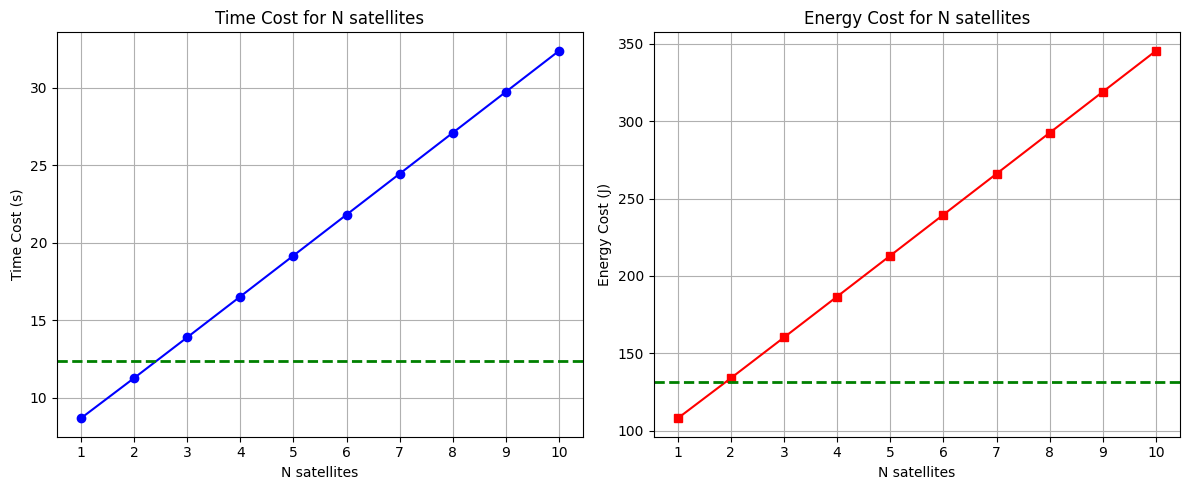

Results exported to even_quadratic_results.csv


In [67]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot
ax1.plot(n_satellites_values, quadratic_time_costs, marker='o', color='blue')
ax1.axhline(y=base_time_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites')
ax1.set_ylabel('Time Cost (s)')
ax1.set_title('Time Cost for N satellites')
ax1.set_xticks(n_satellites_values)
ax1.grid(True)

# Second plot
ax2.plot(n_satellites_values, quadratic_energy_costs, marker='s', color='red')
ax2.axhline(y=base_energy_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites')
ax2.set_ylabel('Energy Cost (J)')
ax2.set_title('Energy Cost for N satellites')
ax2.set_xticks(n_satellites_values)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Export results to CSV
df = pd.DataFrame({
    'n_satellites': n_satellites_values,
    'time_cost': quadratic_time_costs,
    'energy_cost': quadratic_energy_costs
})
df.to_csv('even_quadratic_results.csv', index=False)
print("Results exported to even_quadratic_results.csv")

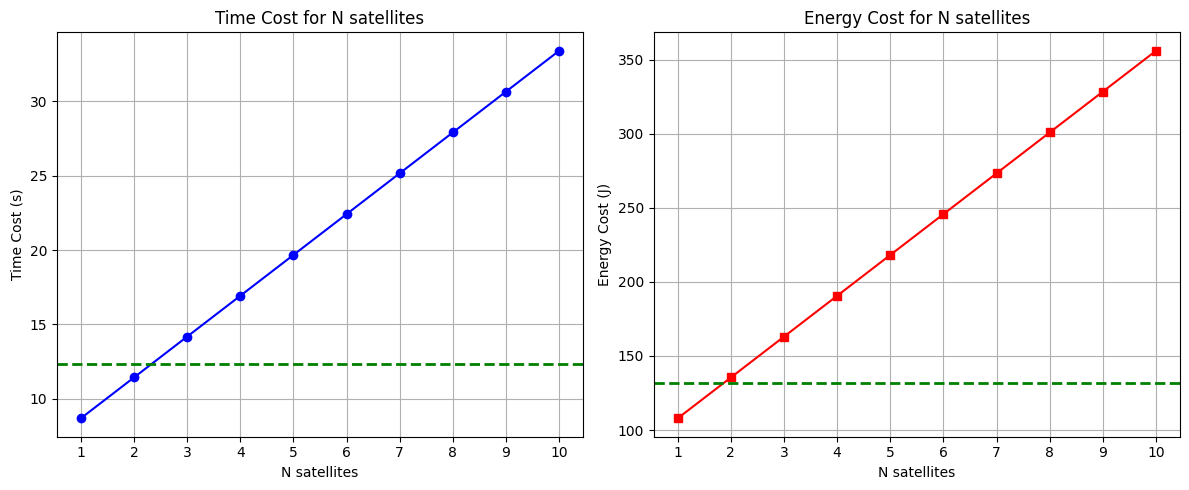

Results exported to even_quadratic_results.csv


In [68]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot
ax1.plot(n_satellites_values, linear_time_costs, marker='o', color='blue')
ax1.axhline(y=base_time_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites')
ax1.set_ylabel('Time Cost (s)')
ax1.set_title('Time Cost for N satellites')
ax1.set_xticks(n_satellites_values)
ax1.grid(True)

# Second plot
ax2.plot(n_satellites_values, linear_energy_costs, marker='s', color='red')
ax2.axhline(y=base_energy_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites')
ax2.set_ylabel('Energy Cost (J)')
ax2.set_title('Energy Cost for N satellites')
ax2.set_xticks(n_satellites_values)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Export results to CSV
df = pd.DataFrame({
    'n_satellites': n_satellites_values,
    'time_cost': linear_time_costs,
    'energy_cost': linear_energy_costs
})
df.to_csv('even_linear_results.csv', index=False)
print("Results exported to even_quadratic_results.csv")

In [69]:
n_satellites = 10

quadratic_time_costs = []
quadratic_energy_costs = []

first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
first_transmission_energy_cost = transmission_energy_cost(
    data_size,
    s_isl,
    config['offloading']['user_satellite']['isl']['energy'],
    config['offloading']['user_satellite']['isl']['distance'])

d_out = data_size

phi_even = np.power(phi, 1/n_satellites)

for sat_id in range(1, n_satellites+1, 1):
    time_cost = processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
    energy_cost = processing_energy_cost(
    d_out,
    config['offloading']['edge_node']['edge_computer']['speed'],
    config['offloading']['edge_node']['edge_computer']['energy_uptime'],
    config['offloading']['edge_node']['edge_computer']['energy_io'])

    quadratic_time_costs.append(first_transmission_time_cost + time_cost)
    quadratic_energy_costs.append(first_transmission_energy_cost + energy_cost)

    d_out = process_data_quadratic(d_out, phi_even)

    if sat_id != n_satellites:
        time_cost = transmission_time_cost(d_out, s_isl)
        energy_cost = transmission_energy_cost(
            d_out,
            s_isl,
            config['offloading']['user_satellite']['isl']['energy'],
            config['offloading']['user_satellite']['isl']['distance'])

        quadratic_time_costs[-1] += time_cost
        quadratic_energy_costs[-1] += energy_cost

time_cost = transmission_time_cost(d_out, config['base']['ground_link']['speed'])
energy_cost = transmission_energy_cost(
    d_out,
    config['base']['ground_link']['speed'],
    config['base']['ground_link']['energy'],
    config['base']['ground_link']['distance'])

quadratic_time_costs[-1] += time_cost
quadratic_energy_costs[-1] += energy_cost

In [70]:
n_satellites = 10

linear_time_costs = []
linear_energy_costs = []

first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
first_transmission_energy_cost = transmission_energy_cost(
    data_size,
    s_isl,
    config['offloading']['user_satellite']['isl']['energy'],
    config['offloading']['user_satellite']['isl']['distance'])

d_out = data_size

final_data_size = data_size * phi
diff = final_data_size - data_size
tau = diff / n_satellites

for sat_id in range(1, n_satellites+1, 1):
    time_cost = processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
    energy_cost = processing_energy_cost(
    d_out,
    config['offloading']['edge_node']['edge_computer']['speed'],
    config['offloading']['edge_node']['edge_computer']['energy_uptime'],
    config['offloading']['edge_node']['edge_computer']['energy_io'])

    linear_time_costs.append(first_transmission_time_cost + time_cost)
    linear_energy_costs.append(first_transmission_energy_cost + energy_cost)

    d_out = process_data_linear(d_out, tau)

    if sat_id != n_satellites:
        time_cost = transmission_time_cost(d_out, s_isl)
        energy_cost = transmission_energy_cost(
            d_out,
            s_isl,
            config['offloading']['user_satellite']['isl']['energy'],
            config['offloading']['user_satellite']['isl']['distance'])

        linear_time_costs[-1] += time_cost
        linear_energy_costs[-1] += energy_cost

time_cost = transmission_time_cost(d_out, config['base']['ground_link']['speed'])
energy_cost = transmission_energy_cost(
    d_out,
    config['base']['ground_link']['speed'],
    config['base']['ground_link']['energy'],
    config['base']['ground_link']['distance'])

linear_time_costs[-1] += time_cost
linear_energy_costs[-1] += energy_cost

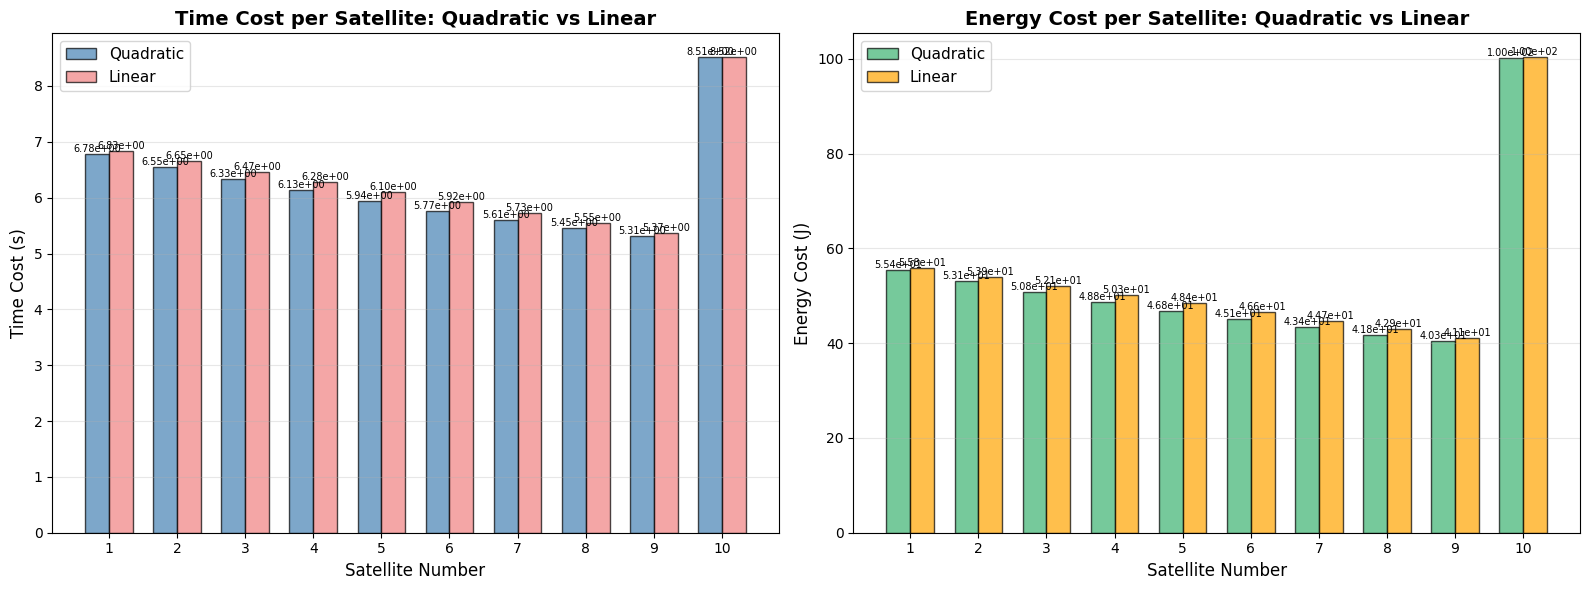


=== Quadratic vs Linear Cost Comparison ===

Per Satellite Costs:
Satellite  Quad Time       Linear Time     Quad Energy     Linear Energy  
---------------------------------------------------------------------------
1          6.7768e+00      6.8333e+00      5.5427e+01      5.5767e+01     
2          6.5462e+00      6.6500e+00      5.3055e+01      5.3928e+01     
3          6.3310e+00      6.4667e+00      5.0841e+01      5.2090e+01     
4          6.1303e+00      6.2833e+00      4.8776e+01      5.0252e+01     
5          5.9430e+00      6.1000e+00      4.6849e+01      4.8413e+01     
6          5.7682e+00      5.9167e+00      4.5051e+01      4.6575e+01     
7          5.6052e+00      5.7333e+00      4.3373e+01      4.4737e+01     
8          5.4530e+00      5.5500e+00      4.1808e+01      4.2898e+01     
9          5.3111e+00      5.3667e+00      4.0348e+01      4.1060e+01     
10         8.5120e+00      8.5167e+00      1.0011e+02      1.0035e+02     

Total      6.2377e+01      6.34

In [71]:
# Satellite numbers for x-axis
satellite_numbers = list(range(1, n_satellites + 1))

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set bar width and positions
bar_width = 0.35
x_pos = np.arange(len(satellite_numbers))

# Plot 1: Time Cost per Satellite (Quadratic vs Linear)
bars1 = ax1.bar(x_pos - bar_width/2, quadratic_time_costs, bar_width,
                label='Quadratic', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax1.bar(x_pos + bar_width/2, linear_time_costs, bar_width,
                label='Linear', color='lightcoral', alpha=0.7, edgecolor='black')

ax1.set_xlabel('Satellite Number', fontsize=12)
ax1.set_ylabel('Time Cost (s)', fontsize=12)
ax1.set_title('Time Cost per Satellite: Quadratic vs Linear', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(satellite_numbers)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars for Plot 1
for i, (quad_cost, lin_cost) in enumerate(zip(quadratic_time_costs, linear_time_costs)):
    ax1.text(i - bar_width/2, quad_cost, f'{quad_cost:.2e}',
             ha='center', va='bottom', fontsize=7, rotation=0)
    ax1.text(i + bar_width/2, lin_cost, f'{lin_cost:.2e}',
             ha='center', va='bottom', fontsize=7, rotation=0)

# Plot 2: Energy Cost per Satellite (Quadratic vs Linear)
bars3 = ax2.bar(x_pos - bar_width/2, quadratic_energy_costs, bar_width,
                label='Quadratic', color='mediumseagreen', alpha=0.7, edgecolor='black')
bars4 = ax2.bar(x_pos + bar_width/2, linear_energy_costs, bar_width,
                label='Linear', color='orange', alpha=0.7, edgecolor='black')

ax2.set_xlabel('Satellite Number', fontsize=12)
ax2.set_ylabel('Energy Cost (J)', fontsize=12)
ax2.set_title('Energy Cost per Satellite: Quadratic vs Linear', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(satellite_numbers)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars for Plot 2
for i, (quad_cost, lin_cost) in enumerate(zip(quadratic_energy_costs, linear_energy_costs)):
    ax2.text(i - bar_width/2, quad_cost, f'{quad_cost:.2e}',
             ha='center', va='bottom', fontsize=7, rotation=0)
    ax2.text(i + bar_width/2, lin_cost, f'{lin_cost:.2e}',
             ha='center', va='bottom', fontsize=7, rotation=0)

plt.tight_layout()
plt.savefig('quadratic_vs_linear_costs.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n=== Quadratic vs Linear Cost Comparison ===")
print("\nPer Satellite Costs:")
print(f"{'Satellite':<10} {'Quad Time':<15} {'Linear Time':<15} {'Quad Energy':<15} {'Linear Energy':<15}")
print("-" * 75)
for sat, q_time, l_time, q_energy, l_energy in zip(satellite_numbers,
                                                     quadratic_time_costs,
                                                     linear_time_costs,
                                                     quadratic_energy_costs,
                                                     linear_energy_costs):
    print(f"{sat:<10} {q_time:<15.4e} {l_time:<15.4e} {q_energy:<15.4e} {l_energy:<15.4e}")

print("\n" + "=" * 75)
print(f"{'Total':<10} {sum(quadratic_time_costs):<15.4e} {sum(linear_time_costs):<15.4e} "
      f"{sum(quadratic_energy_costs):<15.4e} {sum(linear_energy_costs):<15.4e}")

# Calculate differences
time_diff = sum(quadratic_time_costs) - sum(linear_time_costs)
energy_diff = sum(quadratic_energy_costs) - sum(linear_energy_costs)
time_diff_pct = (time_diff / sum(linear_time_costs)) * 100
energy_diff_pct = (energy_diff / sum(linear_energy_costs)) * 100

print(f"\nDifference (Quadratic - Linear):")
print(f"  Time:   {time_diff:+.4e} ({time_diff_pct:+.2f}%)")
print(f"  Energy: {energy_diff:+.4e} ({energy_diff_pct:+.2f}%)")